In [16]:
# Importing dependecies
import pandas as pd
import json
import requests
import prettytable
from config import api_key
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Dictionary of series ID 
category_dict = {
    'CXUFOODAWAYLB1101M': 'Food Away',
    'CXUAPPARELLB1101M': 'Apparel',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash Contribution',
    'CXUALCBEVGLB1101M': 'Alcohol Beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal Care',
    'CXUTOBACCOLB1101M': 'Tobacco'
}

# List of series IDs
category_list = list(category_dict.keys())

In [18]:
# Load the json response for the API queries
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [19]:
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [20]:
df_category = json_df(category_dict)

In [21]:
total = get_total(df_category)

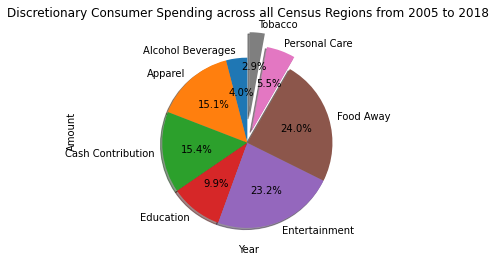

In [22]:
# Labels of the categories
labels = sorted(list(category_dict.values()))

# Explode the two smallest expenses (i.e Tobacco and Personal Care)
explode = (0, 0, 0, 0, 0, 0, .15, .3)  

# Initialize figure and axis
fig1, ax1 = plt.subplots()

# Create pie chart of the breakdown of discretionary spending
ax1.pie(total, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Discretionary Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.show()

In [23]:
# Get percent change over the years, grouped by series ID
df_category['pct_decimal'] = df_category.groupby(['seriesID'])['value'].pct_change()
df_category['percent_change'] = df_category['pct_decimal'].multiply(100)
df_category

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2018,A01,Annual,true,3459.0,,CXUFOODAWAYLB1101M,NaN,NaN
1,2017,A01,Annual,NaN,3365.0,,CXUFOODAWAYLB1101M,-0.027175,-2.717548
2,2016,A01,Annual,NaN,3154.0,,CXUFOODAWAYLB1101M,-0.062704,-6.270431
3,2015,A01,Annual,NaN,3008.0,,CXUFOODAWAYLB1101M,-0.046290,-4.629042
4,2014,A01,Annual,NaN,2787.0,,CXUFOODAWAYLB1101M,-0.073471,-7.347074
...,...,...,...,...,...,...,...,...,...
99,2010,A01,Annual,NaN,362.0,,CXUTOBACCOLB1101M,0.031339,3.133903
100,2009,A01,Annual,NaN,380.0,,CXUTOBACCOLB1101M,0.049724,4.972376
101,2008,A01,Annual,NaN,317.0,,CXUTOBACCOLB1101M,-0.165789,-16.578947
102,2007,A01,Annual,NaN,323.0,,CXUTOBACCOLB1101M,0.018927,1.892744


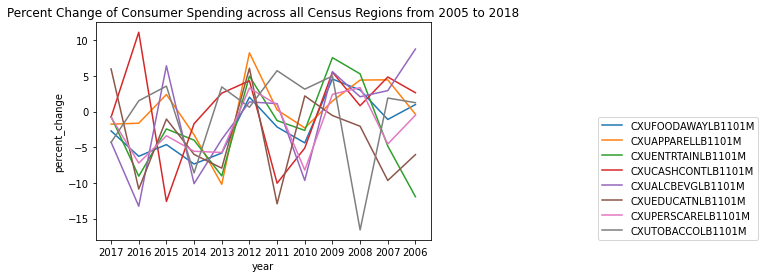

In [24]:
# Produce line chart of percentage change of spend on each item over time
fig,ax = plt.subplots()
for seriesID in list(category_dict.keys()):
    ax.plot(df_category[df_category.seriesID==seriesID].year,
            df_category[df_category.seriesID==seriesID].percent_change,
            label=seriesID)
plt.title('Percent Change of Consumer Spending across all Census Regions from 2005 to 2018')
ax.set_xlabel("year")
ax.set_ylabel("percent_change")
plt.legend(loc=(1.5,0))